In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

import utils as ut        #Includes a function written to help with manipulating the data

The composite analyzed here is of the mixed layer depth in relation to the AMOC for a selected century (years 2645-2744) of a 3000 year long CESM preindustrial control simulation and will look see how well MLD functions as a proxy for the strength of the AMOC. The AMOC index used is maximum AMOC at a specific latitude (30N), which is similar to that calculated by the RAPID array, as described in McCarthy et al (2014). Specifically, the AMOC is compared with the MLD between 0˚-75˚N and 80W˚-0˚, in order to analyze the basic relationshionship between the MLD and deepwater formation in the Atlantic, pertaining to this simulation. The MLD in this simulation is at its greatest in the Spring (MAM), so data from that time is compared with annual means on the AMOC index.

In [2]:
ds_mld = xr.open_dataset('Data/cesm_mld.nc')
ds_amoc = xr.open_dataset('Data/cesm_maxAMOC.nc')

### Selecting the spring (MAM) mixed layer depth and getting the annual means of the AMOC

In [3]:
ds_mld = ut.selectSeason(ds_mld,'MAM') #This function gets the DJF mean MLD at every year
ds_amoc = ds_amoc.groupby('time.year').mean('time')

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
lon = ds_mld['lon']
lat = ds_mld['lat']
yrs = ds_amoc['year']

### Finding the average strength of the AMOC and separating the MLD based on above and below average periods of the AMOC

In [5]:
amoc = ds_amoc['maxAMOC']
mu = amoc.mean(dim='year')
sd = amoc.std()

highAMOC = ds_amoc.where(amoc>mu)
lowAMOC = ds_amoc.where(amoc<mu)

counts = [highAMOC.count(dim='year').values,  lowAMOC.count(dim='year').values]
mldHigh = ds_mld.sel(year=highAMOC.dropna(dim='year')['year']).mean(dim='year')
mldLow = ds_mld.sel(year=lowAMOC.dropna(dim='year')['year']).mean(dim='year')



### Plotting of the AMOC

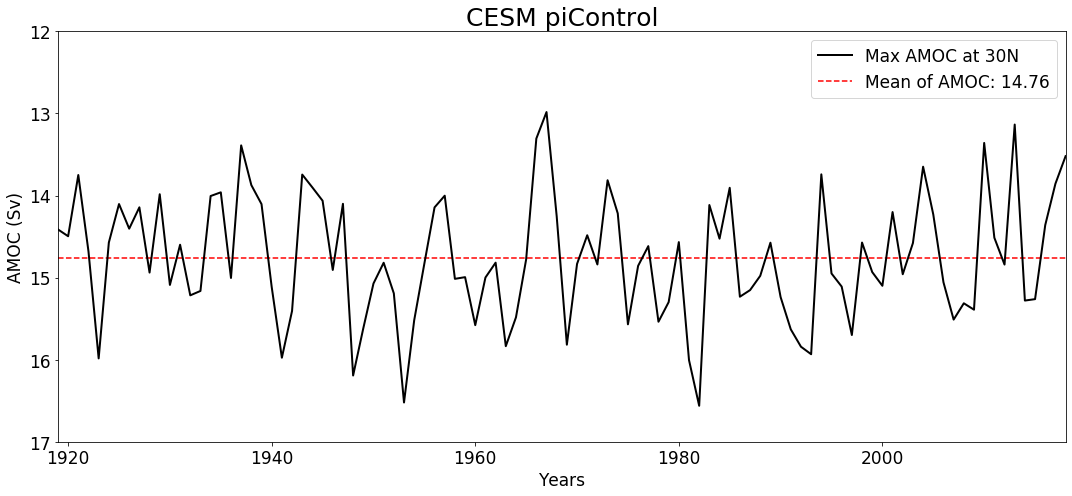

In [6]:
fig = plt.figure(figsize=(15,7))
fs = 17
ax = plt.axes()
ax.plot(yrs,amoc,'k', linewidth=2.)
ax.tick_params(labelsize=fs)
ax.hlines(mu,min(yrs),max(yrs),'r',linestyles='--')
ax.legend(['Max AMOC at 30N', 'Mean of AMOC: '+str(np.round(mu.values,2))],fontsize=fs)

plt.xlabel('Years',fontsize=fs)
plt.ylabel('AMOC (Sv)',fontsize=fs)

plt.axis([min(yrs),max(yrs),17,12])
plt.title('CESM piControl',fontsize=25)
plt.tight_layout()

### Plotting the MLD based in above average and below average strengths of the AMOC circulation (high AMOC and low AMOC, respectively)

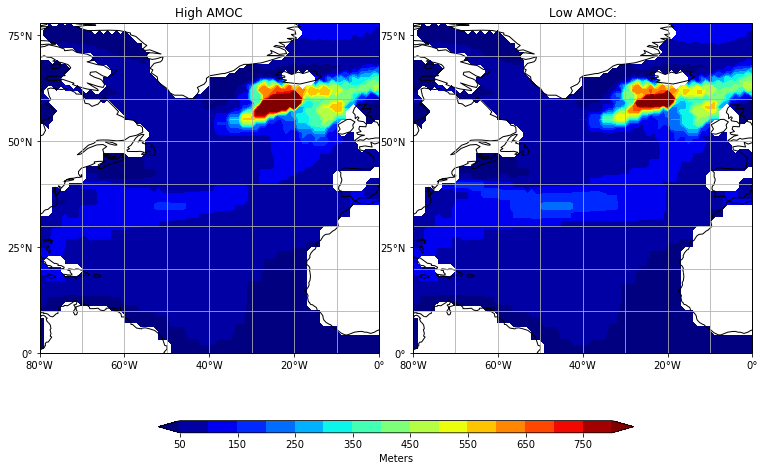

In [7]:
MLDtypes = [mldHigh['mld']/100,mldLow['mld']/100]

fig,ax = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(11.,8.5))
ax = ax.flatten()

clevs = np.arange(50,801,50)
titles = ['High AMOC', 'Low AMOC:']#, 'Difference in AMV\'s']
for i, t in enumerate(titles):
    ax[i].set_extent([-80,0,0,75])
    cs = ax[i].contourf(lon,lat,MLDtypes[i],cmap='jet',transform=ccrs.PlateCarree(),extend='both',levels=clevs)
    
    #Longitude Labels
    ax[i].set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    
    #Latitude Labels
    ax[i].set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[i].yaxis.set_major_formatter(lat_formatter)

    
    ax[i].coastlines()
    ax[i].gridlines()
    ax[i].set_title(t)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.3,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.4)
cbar_ax = fig.add_axes([0.2,0.2,0.6,0.02])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Meters')

### Plotting the difference between above and below average periods of the AMOC (high AMOC - low AMOC)

Text(0.5, 1.0, 'high AMOC - low AMOC')

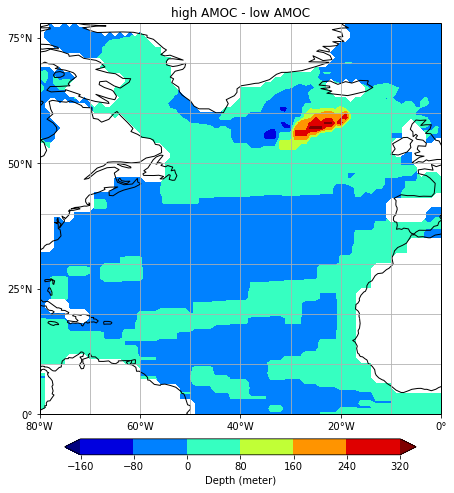

In [8]:
mldDiff = (mldHigh['mld'] - mldLow['mld'])/100

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80,0,0,75])

cs = ax.contourf(lon,lat,mldDiff,cmap='jet',extend='both', transform=ccrs.PlateCarree())
#adding coastlines
ax.coastlines()
#Add Gridlines
ax.gridlines()

#Defining the x-ticks for longitude
ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

#Now getting the y-ticks
ax.set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Calling the colorbar
cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.7, pad = 0.05, label='Depth (meter)')
plt.title('high AMOC - low AMOC')